In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from network import Modele

%load_ext autoreload
# Load the TensorBoard notebook extension

%autoreload 2

In [2]:
#Simple Dataset class for our change detection dataset

class ChangeDetectionDataset(Dataset):
    def __init__(self, csv_file="data.csv", data_dir="./data", batch_size=1, transform=None, crop_size=128):
        self.data = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.transform = transform
        self.batch_size = batch_size
        self.crop_size = crop_size
    def __len__(self):
        return len(self.data)

    def random_crop(self, img1, img2, cm, size):
        x = np.random.randint(0, img1.shape[2]-size)
        y = np.random.randint(0, img1.shape[1]-size)
        img1 = img1[:,y:y+size, x:x+size]
        img2 = img2[:,y:y+size, x:x+size]
        cm = cm[0:1, y:y+size, x:x+size]
        return img1, img2, cm

    def __getitem__(self, idx):
        img1 = read_image(self.data_dir+'/'+self.data.iloc[idx,0])
        img2 = read_image(self.data_dir+'/'+self.data.iloc[idx,1])
        cm = read_image(self.data_dir+'/'+self.data.iloc[idx,2])


        img1Tensor = torch.zeros((3, self.crop_size, self.crop_size), dtype=torch.float32)
        img2Tensor = torch.zeros((3, self.crop_size, self.crop_size), dtype=torch.float32)
        cmTensor = torch.zeros((1, self.crop_size, self.crop_size), dtype=torch.float32)

        
        crop1, crop2, cropcm = self.random_crop(img1[:,:,:], img2[:,:,:], cm[:,:,:], self.crop_size)
        img1Tensor[:,:,:] = crop1.float()/255
        img2Tensor[:,:,:] = crop2.float()/255
        cmTensor[:,:,:] = cropcm.float()
        #apply the same transformation to all images as batch dimension
        return img1Tensor, img2Tensor, cmTensor
        

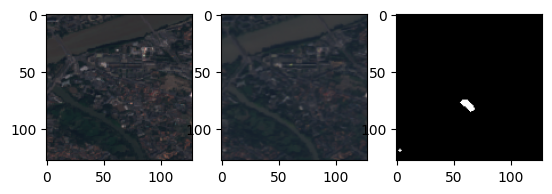

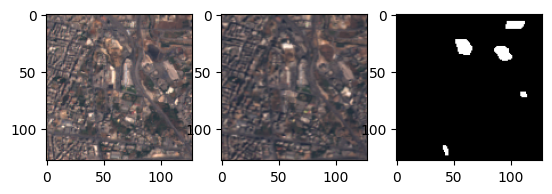

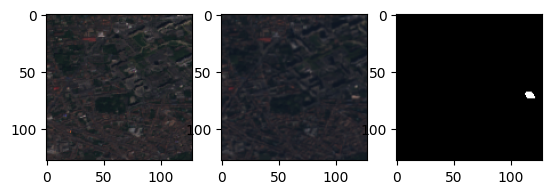

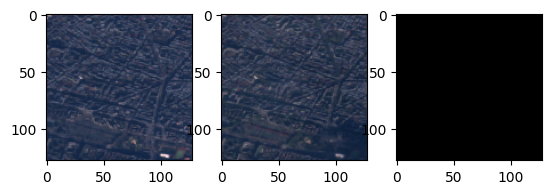

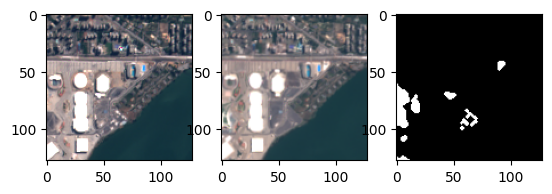

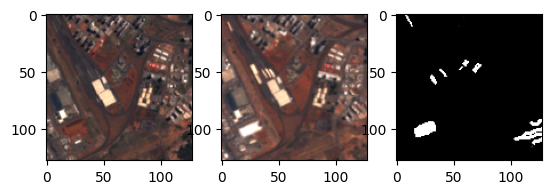

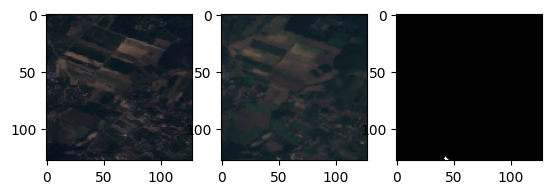

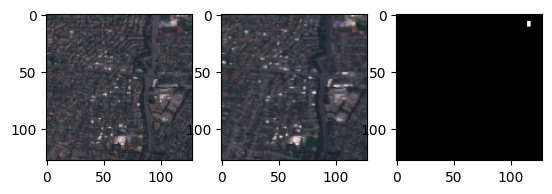

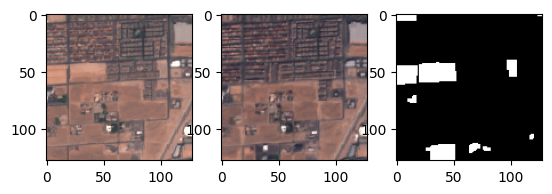

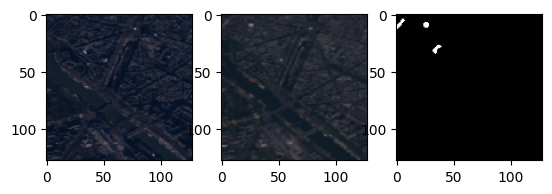

In [3]:
#Simple DataLoader class for our change detection dataset
batch_size = 10

train_dataset= ChangeDetectionDataset(data_dir="data",csv_file="train.csv", batch_size=batch_size, transform=None)
val_dataset = ChangeDetectionDataset(data_dir="data",csv_file="val.csv", batch_size=1, transform=None)
train_loader = DataLoader(batch_size=batch_size, dataset=train_dataset, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, shuffle=True)
#Simple function to display a batch of images

def show_batch(batch):
    img1s, img2s, cms = batch

    for i in range(len(img1s)):
        img1 = img1s[i,:,:,:]
        img2 = img2s[i,:,:,:]
        cm = cms[i,:,:,:]
        fig, ax = plt.subplots(1,3)
        ax[0].imshow(img1.permute(1,2,0))
        ax[1].imshow(img2.permute(1,2,0))
        ax[2].imshow(cm.permute(1,2,0), cmap='gray')
        plt.show()

a = next(iter(train_loader))
show_batch(a)

In [4]:
n_epoch = 1
learning_rate = 0.0001
model = Modele()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss, val_loss = [], []


for epoch in range(n_epoch):
    model.train()
    accu = 0

    for img1,img2,cm in train_loader:
        #Forward pass
        y_pred = model(img1, img2)
        loss = loss_fn(y_pred, cm)
        accu += loss.item()
        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(accu/len(train_loader))

    model.eval()
    for img1,img2,cm in val_loader:
        y_pred=model(img1,img2)
        loss = loss_fn(y_pred,cm)
        accu += loss.item()
    val_loss.append(accu/len(val_loader))
    print(f"Train {epoch}: {train_loss[-1]} and Valid {epoch}: {val_loss[-1]}")

c:\Python312\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([10, 1, 128, 128])) that is different to the input size (torch.Size([10, 3, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (512) must match the size of tensor b (128) at non-singleton dimension 3